In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pandas.core.common import flatten
from functools import partial, reduce

In [2]:
import sys
sys.path.append('../../')

In [3]:
from config.constants import *

In [4]:
plt.style.use('ggplot')

In [5]:
pairs_list = [
    'XAUUSD/XAUUSD_H4 - XAUUSD_H4',
]

In [6]:
df ={}
for pair in range(len(pairs_list)) :
    df[pair] = pd.read_csv(PATH_DATA + SYMBOL['XAUUSD']['H4'] + '.csv',index_col='Time',parse_dates=True)

In [7]:
def SMA(df, fast, slow):
    df['sma_fast'] = df['Close'].rolling(fast).mean()
    df['sma_slow'] = df['Close'].rolling(slow).mean()
    return df

def ATR(df, n):
    df = df.copy()
    df['High-Low'] = abs(df['High'] - df['Low'])
    df['High-PrevClose'] = abs(df['High'] - df['Close'].shift(1))
    df['Low-PrevClose'] = abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['High-Low', 'High-PrevClose', 'Low-PrevClose']].max(axis = 1, skipna = False)
    df['ATR'] = df['TR'].rolling(n).mean()
    df = df.drop(['High-Low', 'High-PrevClose', 'Low-PrevClose'], axis = 1)
    return df

In [8]:
#Strategy parameters
account_size = 2000
slippage = 2
size = 1
ATR_SL = 0.5

for pair in range(len(pairs_list)):
    df[pair]['ATR'] = ATR(df[pair], 20)['ATR']
    df[pair]['sma_fast'] = SMA(df[pair], 50, 200)['sma_fast']
    if 'USDJPY/USDJPY_H4 - USDJPY_H4'  not in pairs_list[pair] and 'XAUUSD/XAUUSD_H4 - XAUUSD_H4'  not in pairs_list[pair] :
        df[pair]['spread'] = float(slippage) / float(10000)
        df[pair]['size'] = float(size) * float(10000)
        print('Pair: ', pairs_list[pair], 'a')
    else:
        df[pair]['spread'] = float(slippage) / float(100)
        df[pair]['size'] = float(size) * float(100)
        print('Pair: ', pairs_list[pair], 'b')

Pair:  XAUUSD/XAUUSD_H4 - XAUUSD_H4 b


In [9]:
df[0][200:202]

,Open,High,Low,Close,Volume,ATR,sma_fast,sma_slow,spread,size
Time,,,,,,,,,,
2007-02-14 08:00:00,668.170,670.207,666.899,667.768,235,3.7988,656.51950,637.895595,0.02,100.0
2007-02-14 12:00:00,667.574,671.708,665.393,667.841,239,3.9045,656.97644,638.056305,0.02,100.0


In [10]:
open_trade = {}
trade = {}
long_take_profit = {}
short_take_profit = {}
long_stop_loss = {}
short_stop_loss = {}
long_entry_price = {}
short_entry_price = {}

for pair in range(len(pairs_list)):
    open_trade[pair] = []
    trade[pair] = {}
    long_take_profit[pair] = []
    short_take_profit[pair] = []
    long_stop_loss[pair] = []
    short_stop_loss[pair] = []
    long_entry_price[pair] = []
    short_entry_price[pair] = []
    
    for i in range(50, len(df[pair])):
        #Buy
        if df[pair]['sma_fast'][i-1] < df[pair]['sma_slow'][i-1] and df[pair]['sma_fast'][i] >= df[pair]['sma_slow'][i] and len(open_trade[pair]) == 0:
          
            print(i, 'New Long trade at price:', round(df[pair]['Close'][i], 4), ' On day:', df[pair].index[i], 'Pair:', pairs_list[pair])
            trade[pair][i] = {'ID': i,
                             'date_of_trade': df[pair].index[i],
                             'entry_price': df[pair]['Close'][i],
                             'signal': 'Buy',
                             'result': 0, 
                             'TP': df[pair]['Close'][i] + df[pair]['ATR'][i] * ATR_SL,
                             'SL': df[pair]['Close'][i] - df[pair]['ATR'][i] * ATR_SL} 
            
            
            open_trade[pair].append(i)
            long_take_profit[pair].append(trade[pair][i]['TP'])
            long_stop_loss[pair].append(trade[pair][i]['SL'])
            long_entry_price[pair].append(trade[pair][i]['entry_price'])
        
        #Sell
        if df[pair]['sma_fast'][i-1] > df[pair]['sma_slow'][i-1] and df[pair]['sma_fast'][i] <= df[pair]['sma_slow'][i] and len(open_trade[pair]) == 0:
            print(i, 'New Short trade at price:', round(df[pair]['Close'][i], 4), ' On day:', df[pair].index[i], 'Pair:', pairs_list[pair])
            trade[pair][i] = {'ID': i,
                             'date_of_trade': df[pair].index[i],
                             'entry_price': df[pair]['Close'][i],
                             'signal': 'Sell',
                             'result': 0, 
                             'TP': df[pair]['Close'][i] - df[pair]['ATR'][i] * ATR_SL,
                             'SL': df[pair]['Close'][i] + df[pair]['ATR'][i] * ATR_SL}
            open_trade[pair].append(i)
            short_take_profit[pair].append(trade[pair][i]['TP'])
            short_stop_loss[pair].append(trade[pair][i]['SL'])
            short_entry_price[pair].append(trade[pair][i]['entry_price'])
            
        #Exit trades---------------------------------------------------------------------------
        #Buy profit
        if any(y <= df[pair]['Close'][i] for y in long_take_profit[pair]):
            for j in open_trade[pair]:
                if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Buy':
                    if df[pair]['Close'][i] >= trade[pair][j]['TP']:
                        trade[pair][j].update({'result' : (trade[pair][j]['TP'] - trade[pair][j]['entry_price'] - df[pair]['spread'][i]) * df[pair]['size'][i]})
                        print(j, 
                             'Long profit at price:', round(df[pair]['Close'][i], 4),
                             'On day:', df[pair].index[i],
                             'With profit:', round(trade[pair][j]['result'], 4), '\n')
                        open_trade[pair].remove(j)
                        long_take_profit[pair].remove(trade[pair][j]['TP'])
                        long_stop_loss[pair].remove(trade[pair][j]['SL'])
        #Buy loss
        if any(y >= df[pair]['Close'][i] for y in long_stop_loss[pair]):
            for j in open_trade[pair]:
                if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Buy':
                    if df[pair]['Close'][i] <= trade[pair][j]['SL']:
                        trade[pair][j].update({'result' : (trade[pair][j]['SL'] - trade[pair][j]['entry_price'] - df[pair]['spread'][i]) * df[pair]['size'][i]})
                        print(j, 
                             'Long loss at price:', round(df[pair]['Close'][i], 4),
                             'On day:', df[pair].index[i],
                             'With loss:', round(trade[pair][j]['result'], 4), '\n')
                        open_trade[pair].remove(j)
                        long_take_profit[pair].remove(trade[pair][j]['TP'])
                        long_stop_loss[pair].remove(trade[pair][j]['SL'])
                        
        #Sell profit
        if any(y >= df[pair]['Close'][i] for y in short_take_profit[pair]):
            for j in open_trade[pair]:
                if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Sell':
                    if df[pair]['Close'][i] <= trade[pair][j]['TP']:
                        trade[pair][j].update({'result' : (trade[pair][j]['entry_price'] - trade[pair][j]['TP'] - df[pair]['spread'][i]) * df[pair]['size'][i]})
                        print(j, 
                             'Short profit at price:', round(df[pair]['Close'][i], 4),
                             'On day:', df[pair].index[i],
                             'With profit:', round(trade[pair][j]['result'], 4), '\n')
                        open_trade[pair].remove(j)
                        short_take_profit[pair].remove(trade[pair][j]['TP'])
                        short_stop_loss[pair].remove(trade[pair][j]['SL'])
        #Sell loss
        if any(y <= df[pair]['Close'][i] for y in short_stop_loss[pair]):
            for j in open_trade[pair]:
                if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Sell':
                    if df[pair]['Close'][i] >= trade[pair][j]['SL']:
                        trade[pair][j].update({'result' : (trade[pair][j]['entry_price'] - trade[pair][j]['SL'] - df[pair]['spread'][i]) * df[pair]['size'][i]})
                        print(j, 
                             'Short loss at price:', round(df[pair]['Close'][i], 4),
                             'On day:', df[pair].index[i],
                             'With loss:', round(trade[pair][j]['result'], 4), '\n')
                        open_trade[pair].remove(j)
                        short_take_profit[pair].remove(trade[pair][j]['TP'])
                        short_stop_loss[pair].remove(trade[pair][j]['SL'])
        #Exit after time
        if len(open_trade[pair]) != 0:
            for j in open_trade[pair]:
                if (i - trade[pair][j]['ID']) >= 12 and trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Buy':
                    trade[pair][j].update({'result' : (df[pair]['Close'][i] - trade[pair][j]['entry_price'] - df[pair]['spread'][i]) * df[pair]['size'][i]})
                    print(j, 
                         'Long exited after 48 hours:', round(df[pair]['Close'][i], 4),
                         'On day:', df[pair].index[i],
                         'With profit:', round(trade[pair][j]['result'], 4), '\n')
                    open_trade[pair].remove(j)
                    long_take_profit[pair].remove(trade[pair][j]['TP'])
                    long_stop_loss[pair].remove(trade[pair][j]['SL'])
                elif (i - trade[pair][j]['ID']) >= 12 and trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Sell':
                    trade[pair][j].update({'result' : (trade[pair][j]['entry_price'] - df[pair]['Close'][i] - df[pair]['spread'][i]) * df[pair]['size'][i]})
                    print(j, 
                         'Short exited after 48 hours:', round(df[pair]['Close'][i], 4),
                         'On day:', df[pair].index[i],
                         'With profit:', round(trade[pair][j]['result'], 4), '\n')
                    open_trade[pair].remove(j)
                    short_take_profit[pair].remove(trade[pair][j]['TP'])
                    short_stop_loss[pair].remove(trade[pair][j]['SL'])

300 New Short trade at price: 651.611  On day: 2007-03-08 12:00:00 Pair: XAUUSD/XAUUSD_H4 - XAUUSD_H4
300 Short profit at price: 648.042 On day: 2007-03-09 16:00:00 With profit: 274.575 

389 New Long trade at price: 665.148  On day: 2007-03-28 20:00:00 Pair: XAUUSD/XAUUSD_H4 - XAUUSD_H4
389 Long loss at price: 658.572 On day: 2007-03-29 12:00:00 With loss: -170.395 

599 New Short trade at price: 671.554  On day: 2007-05-15 16:00:00 Pair: XAUUSD/XAUUSD_H4 - XAUUSD_H4
599 Short profit at price: 665.931 On day: 2007-05-16 12:00:00 With profit: 175.9675 

853 New Long trade at price: 660.572  On day: 2007-07-11 16:00:00 Pair: XAUUSD/XAUUSD_H4 - XAUUSD_H4
853 Long profit at price: 663.27 On day: 2007-07-12 04:00:00 With profit: 140.5625 

1018 New Short trade at price: 650.87  On day: 2007-08-17 08:00:00 Pair: XAUUSD/XAUUSD_H4 - XAUUSD_H4
1018 Short loss at price: 657.198 On day: 2007-08-17 12:00:00 With loss: -240.1475 

1094 New Long trade at price: 680.796  On day: 2007-09-04 12:00:00 

In [11]:
pairs_results = {}
profits = {}
losses = {}
be = {}

for pair in range(len(pairs_list)):
    profits[pair] = []
    losses[pair] = []
    be[pair] = []
    
    pairs_results[pair] = pd.DataFrame.from_dict({(i, j): trade[pair][j] for j in trade[pair].keys()}, orient = 'index')
    pairs_results[pair] = pairs_results[pair].drop(['signal', 'ID', 'TP', 'SL'], axis = 1)
    pairs_results[pair].set_index('date_of_trade', inplace = True)
    pairs_results[pair]['cum_res'] = pairs_results[pair]['result'].cumsum() + account_size
    
    for t in trade[pair]:
        profits[pair].append(trade[pair][t]['result']) if trade[pair][t]['result'] > 0.1 else ''
        losses[pair].append(trade[pair][t]['result']) if trade[pair][t]['result'] < -0.1 else ''
        be[pair].append(trade[pair][t]['result']) if -0.1 <= trade[pair][t]['result'] <= 0.1 else ''
        
my_reduce = partial(pd.merge, on = 'date_of_trade', how = 'outer')

strategy_results = reduce(my_reduce, pairs_results.values())
strategy_results = strategy_results.sort_index()
strategy_results['final_res'] = strategy_results.filter(like = 'result', axis = 1).sum(axis = 1)
strategy_results['cum_res'] = strategy_results['final_res'].cumsum() + account_size
print(pairs_results.values())

profits_keys = list(profits.keys())
profits_values = [profits[x] for x in profits_keys]
str_profits = list(flatten(profits_values))

losses_keys = list(losses.keys())
losses_values = [losses[x] for x in losses_keys]
str_losses = list(flatten(losses_values))

be_keys = list(be.keys())
be_values = [be[x] for x in be_keys]
str_be = list(flatten(be_values))

dict_values([                     entry_price    result    cum_res
date_of_trade                                        
2007-03-08 12:00:00      651.611  274.5750  2274.5750
2007-03-28 20:00:00      665.148 -170.3950  2104.1800
2007-05-15 16:00:00      671.554  175.9675  2280.1475
2007-07-11 16:00:00      660.572  140.5625  2420.7100
2007-08-17 08:00:00      650.870 -240.1475  2180.5625
...                          ...       ...        ...
2022-08-28 20:00:00     1734.654  341.3800   110.1100
2022-10-11 08:00:00     1670.086  444.5175   554.6275
2022-10-16 20:00:00     1647.398 -480.9925    73.6350
2022-11-10 08:00:00     1707.308  469.3675   543.0025
2023-02-13 00:00:00     1858.645 -441.1225   101.8800

[160 rows x 3 columns]])


Strategy returns: -1898


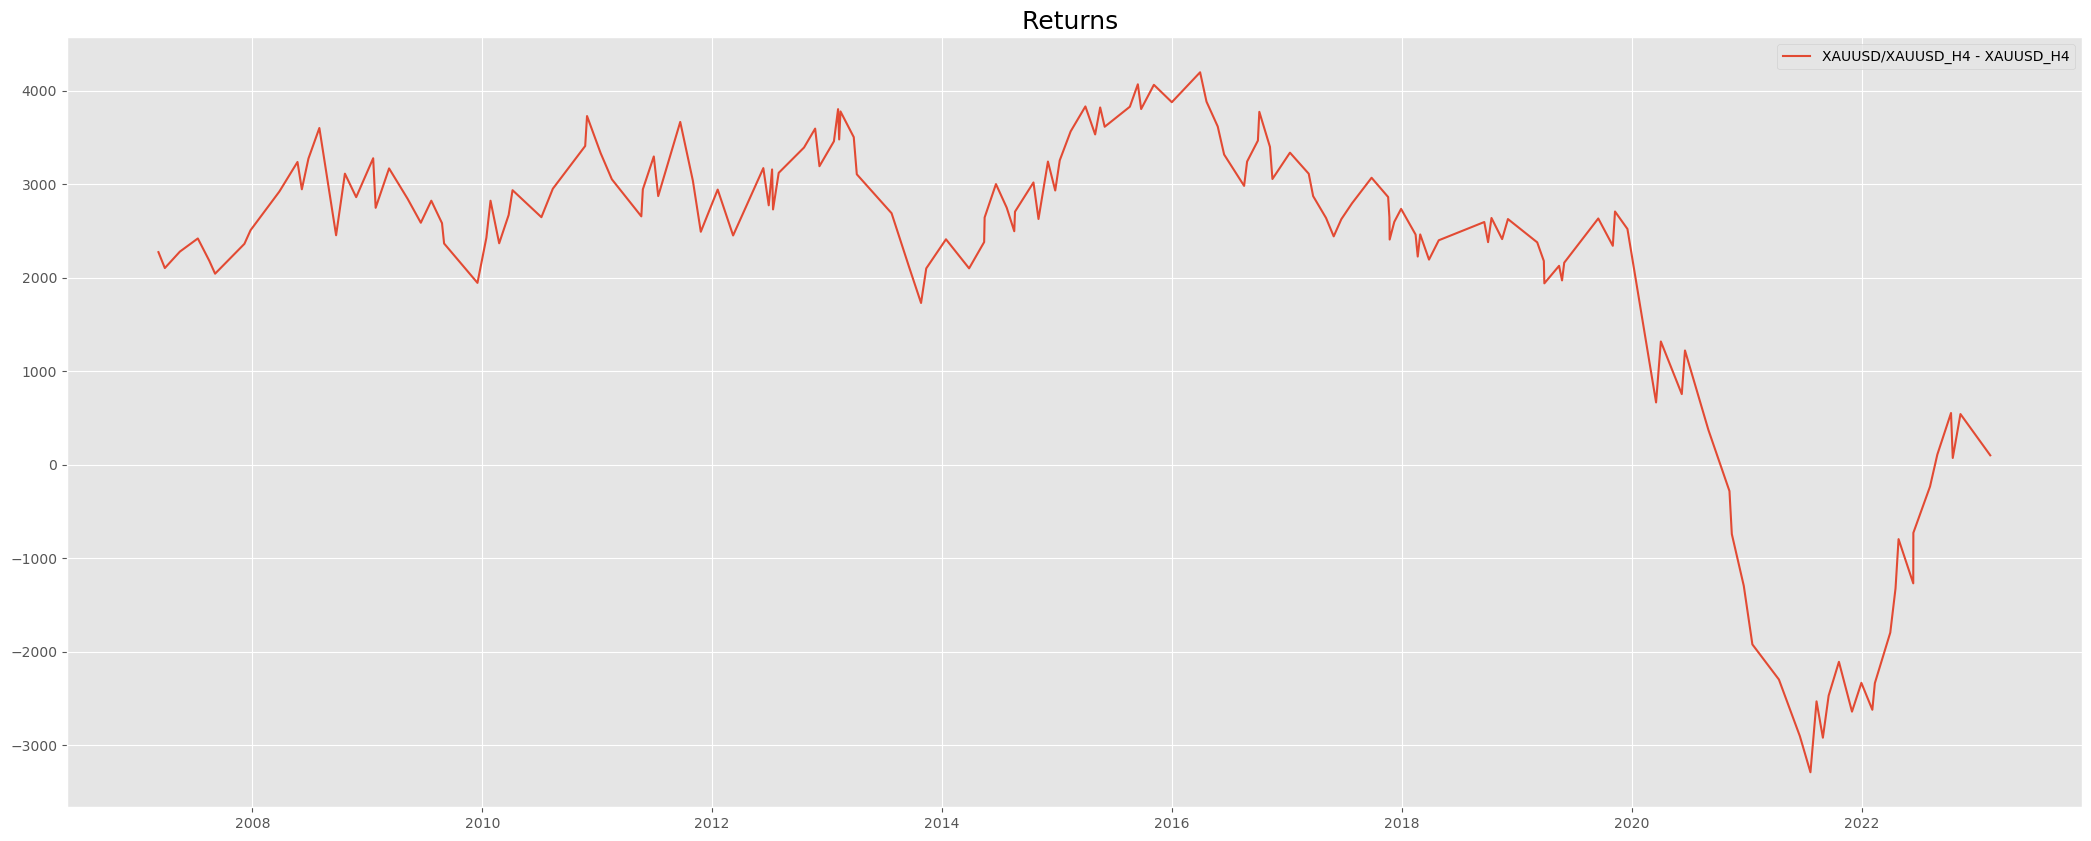

In [12]:
plt.figure(figsize = (26, 10))
for pair in range(len(pairs_list)):
    plt.plot(pairs_results[pair]['cum_res'], label = pairs_list[pair])
plt.legend()
plt.title('Returns ', fontsize = 18)


print('Strategy returns:', round(strategy_results['cum_res'][-1]) - account_size)